In [1]:
import tensorflow as tf

In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
from tensorflow.keras.applications.vgg19 import VGG19

In [4]:
model=VGG19(include_top=False,weights="imagenet")

In [5]:
model.trainable=False

In [6]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [7]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def load_and_preprocess_image(image_path):
    img=load_img(image_path)
    img=img_to_array(img)
    img=preprocess_input(img)
    img=np.expand_dims(img,axis=0)
    return img

In [9]:
def deprocess_img(x):
    x[:,:,0]+=103.939
    x[:,:,1]+=116.779
    x[:,:,2]+=123.68
    x=x[:,:,::-1]
    x=np.clip(x,0,255).astype('uint8')
    return x

In [10]:
def display_image(image):
    
    if  (len(image.shape)==4):
        img=np.squeeze(image,axis=0)
    img=deprocess_img(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return 

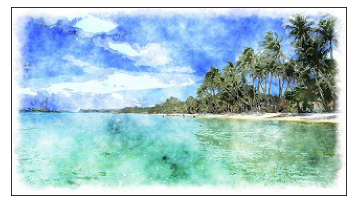

In [11]:
display_image(load_and_preprocess_image("style.jpg"))

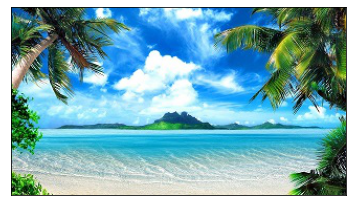

In [12]:
display_image(load_and_preprocess_image("content.jpg"))

In [13]:
print(load_and_preprocess_image("content.jpg").shape)
print(load_and_preprocess_image("style.jpg").shape)

(1, 180, 320, 3)
(1, 180, 320, 3)


In [14]:
content_layer="block5_conv3"
content_model=Model(inputs=model.input,outputs=model.get_layer(content_layer).output)

style_layers=["block1_conv1","block3_conv1","block5_conv1"]
style_models=[Model(inputs=model.input,outputs=model.get_layer(layer).output) for layer in style_layers]

In [15]:
def content_cost(content,generated):
    a_s=content_model(content)
    a_g=content_model(generated)
    cost=tf.reduce_sum(tf.square(a_s-a_g))
    return cost

In [16]:
def gram_matrix(A):
    n_channels=int(A.shape[-1])
    a=tf.reshape(a,[-1,n_channels])
    n=tf.shape(a)[0]
    g=tf.matmul(a,a,transpose_a=True)
    return g/tf.cast(n,float32)

In [17]:
def style_cost(content,generated):
    c=1/len(style_models)
    total_cost=0
    for style_model in style_models:
        a_s=style_model(content)
        a_g=style_model(generated)
        gs=gram_matrix(a_s)
        gg=gram_matrix(a_g)
        current_cost+=tf.reduce_mean(tf.square(gs-gg))
        total_cost+=current_cost
    return total_cost

In [18]:
import time

In [19]:
generated_images=[]
def training_loop(content_path,style_path,iterations=200,alpha=10.0,beta=20.0):
    
    content=load_and_preprocess_image(content_path)
    style=load_and_preprocess_image(style_path)
    generated=tf.Variable(content,dtype=tf.float32)
    
    opt=tf.compat.v1.train.AdamOptimizer(learning_rate=7.0)
    best_cost=1e12+0.1
    best_image=None
    start_time=time.time()
    
    for i in range(iterations):
        with tf.GradientTape() as tape:
            J_content=content_cost(content,generated)
            J_style=content_cost(style,generated)
            J_total=alpha*J_content+beta*J_style
            
        grads=tape.gradient(J_total,generated)
        opt.apply_gradients([(grads,generated)])
        
        if J_total<best_cost:
            best_cost=J_total
            best_image=generated.numpy()
            
        print("cost at {}:{}. Time elapsed : {} ".format(i,J_total,time.time()-start_time))
        generated_images.append(generated.numpy())
    
    return best_image

In [20]:
best_image=training_loop("content.jpg","style.jpg")

cost at 0:2406838784.0. Time elapsed : 2.665661573410034 
cost at 1:1841735168.0. Time elapsed : 3.1171958446502686 
cost at 2:1544901632.0. Time elapsed : 3.5677297115325928 
cost at 3:1462662912.0. Time elapsed : 4.0195229053497314 
cost at 4:1410757760.0. Time elapsed : 4.471917629241943 
cost at 5:1369695488.0. Time elapsed : 4.922905683517456 
cost at 6:1336758528.0. Time elapsed : 5.371705532073975 
cost at 7:1313488896.0. Time elapsed : 5.822393178939819 
cost at 8:1295938560.0. Time elapsed : 6.272536754608154 
cost at 9:1275901184.0. Time elapsed : 6.72439169883728 
cost at 10:1259510144.0. Time elapsed : 7.174848794937134 
cost at 11:1245614208.0. Time elapsed : 7.623226165771484 
cost at 12:1233149696.0. Time elapsed : 8.073154211044312 
cost at 13:1223862272.0. Time elapsed : 8.52199912071228 
cost at 14:1215341440.0. Time elapsed : 8.97503113746643 
cost at 15:1204985344.0. Time elapsed : 9.425565242767334 
cost at 16:1196005376.0. Time elapsed : 9.87554669380188 
cost at 

cost at 138:1007424128.0. Time elapsed : 69.15824699401855 
cost at 139:1007605376.0. Time elapsed : 69.65994644165039 
cost at 140:1007494528.0. Time elapsed : 70.18051171302795 
cost at 141:1007109248.0. Time elapsed : 70.7081036567688 
cost at 142:1006112256.0. Time elapsed : 71.281569480896 
cost at 143:1006054016.0. Time elapsed : 71.79116797447205 
cost at 144:1005886080.0. Time elapsed : 72.31476712226868 
cost at 145:1005305408.0. Time elapsed : 72.93909859657288 
cost at 146:1005496832.0. Time elapsed : 73.5056381225586 
cost at 147:1005220096.0. Time elapsed : 73.99208927154541 
cost at 148:1004820480.0. Time elapsed : 74.50877356529236 
cost at 149:1004103040.0. Time elapsed : 75.01756429672241 
cost at 150:1003846784.0. Time elapsed : 75.52022576332092 
cost at 151:1003575168.0. Time elapsed : 76.01931953430176 
cost at 152:1003162944.0. Time elapsed : 76.53793525695801 
cost at 153:1003320384.0. Time elapsed : 77.04558253288269 
cost at 154:1002829568.0. Time elapsed : 77.

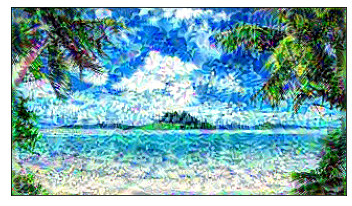

In [21]:
display_image(best_image)